In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

# Load and Clean Data

In [6]:
# companies = pd.read_csv('masked_3_NAICS_codes_20190520 (with LineOfBusiness and Officer) - masked_3_NAICS_codes_20190503.csv')
companies = pd.read_excel('/Users/rdou/Ran Dou/FINCURA-Insights/Data/masked_3_NAICS_codes_20190520 (with LineOfBusiness and Officer).xlsx')

In [7]:
# show missing values in each column
print ('Companies: %.0f, Fields: %.0f' % (companies.shape))
companies.isnull().sum()

Companies: 1092, Fields: 325


masked EntityID                       0
CPR $net_inc_YTD                    666
CPR_Group                           666
CPR_rm                              666
IndustryCode                          0
IndustryClass                         0
IndustryType                        245
entityID_x                            0
customerID_C                          0
customerID_m                          0
rank_by_dt                            0
rank_by_stmt_id                       0
CustomerID                            0
ContextID                             0
StatementID                           0
CustomerName                          0
StatementDate                         0
StatementMonths                       0
AuditMethod                           1
Accountant                          344
Analyst                              49
StatementType                         0
Cash                                  1
MarketableSec                         4
AcctsRecTrade                         0


In [8]:
# show missing values by row
len(companies[pd.isnull(companies).any(axis=1)])

1092

In [9]:
# is there any rows for which we have essentially no data at all?
max(companies.isnull().sum(axis=1))

161

161 values missing in the same row isn't great. I suspect we'll run across this when we go through each field.

## Data Cleanup

All rows have one missing value. Let's run through the columns to do some data cleanup.

### Part I: Handle Missing Values

In [10]:
companies.head(1)

,masked EntityID,CPR $net_inc_YTD,CPR_Group,CPR_rm,IndustryCode,IndustryClass,IndustryType,entityID_x,customerID_C,customerID_m,rank_by_dt,rank_by_stmt_id,CustomerID,ContextID,StatementID,CustomerName,StatementDate,StatementMonths,AuditMethod,Accountant,Analyst,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,OffBSCurAsts,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,GrossFixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,OffBSNonCurAsts,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,OtherOperIncome,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,IncomeTaxCredit,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AftTaxNonCashExp,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,CovWorkingCapital,CovCapitalExpend,CovOwnerSalary,CovLeaseExpend,CovDividends,CovSubDebtPaymts,CovNewDebt,CovMinimumTNW,CovMinCashBal,CovCurrentRatio,CovQuickRatio,CovDebtToTNW,CovInterestCover,CovFundsFlwCover,CovProfitMargin,CovRetOnEquity,CovRetOnAssets,CovAcctsRecDays,CovInventoryDays,CovAcctsPayDays,CovMaxSalesGrow,WorkingCapital,QuickRatio,CurrentRatio,TangibleNetWorth,EffTangNetWorth,DebtToWorth,DebtToTNW,DbtLessSubEffTNW,LiabsToAssets,InterestCoverage,FndsFlwToPpCPLTD,UCACashFlowCover,CashFlwToPpCPLTD,EBITDA,EBIDA,FixedChargeCover,ReturnOnAssets,ReturnOnEquity,GrossMargin,OpProfitMargin,DivPayoutRate,EffectiveTaxRate,GrsAcctsRecDays,NetAcctsRecDays,RawMatInvDays,WIPInvDays,FinGoodsInvDays,TotalInvDays,AcctsPayableDays,SalesToTotalAsts,SalesToWrkingCap,SalesToNetWorth,SalesToFixedAsts,PBTToTotalAssets,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,SustainableGrow,CashClctdFrSales,CashPdToSupplrs,CashFrTradActiv,CashPdForOpCosts,CashAfterOps,OthIncAndTaxesPd,NetCashAfterOps,CashPdDivAndInt,NetCashIncome,CPLTDPaid,CashAftDebtAmort,ChgInFixedAssets,FixedAssetsToTNW,ProfitB4TaxToTNW,DepAmortToSales,OffrCompToSales,SalesToAcctsRec,COGSToInventory,COGSToAcctsPay,PBTToNetSales,OtherCurAssets,OtherNonCurAsts,OtherCurLiabs,OtherNonCurLiabs,StatementYear,CashAndEquivs,NetMargin,NetIncDeprtoCPLTD,AcctsRecRelCo,OverdraftsInt,BorrFundtoEffTgWth,EBITDAtoIntCPLTD,CapInterest,AdjustedEBITDA,AdjustedEBITDAGrowth,AdjustedEBITDAMargin,GrossProfitGrowth,ImpliedCFGRating,OCF,SeniorFundedDebt,SFDtoAdjEBITDA,TFDtoAdjEBITDA,TotalFundedDebt,ZScore,ChgInWorkingInvestment,TangibleCapitalBase,MaintenanceCapX,SynergiesAddbacks,CashTaxes,RecurringDistributions,ExtraordinaryItems,OCFADSR,OCFCapXADSR,OCFCapXWIADSR,ChginGrossFixedAssets,Inventory,BuildingsImprovements,MachineryEquipment,FurnitureFixtures,LeaseholdImprovements,TransportationEquipment,CapitalLeases,CREATE_BY_NM,CREATE_BY_DT,LAST_UPDATE_BY_NM,LAST_UPDATE_BY_DT,DepreciationandAmortization,GainOnDeriv,LossOnDeriv,GainonAssetReval,LossonAssetReval,GainLossonAs

In [11]:
def clean_data(companies):
    """ Clean up citizens spreads """
    
    # drop columns that don't contain meaningful info
    cols_to_drop = [
        'IndustryClass',
        'rank_by_dt',
        'rank_by_stmt_id',
        'ContextID',
        'entityID_x',
        'customerID_m',
        'customerID_C',
        'CREATE_BY_NM',
        'CREATE_BY_DT',
        'LAST_UPDATE_BY_NM',
        'LAST_UPDATE_BY_DT',
    ]
    companies = companies.drop(cols_to_drop, axis=1)
    
    # replace 999.0 and -999.0 with NaN
    companies = companies.replace(999.0, np.nan).replace(-999.0, np.nan)
    
    # IndustryType - fill in using matching NAICS codes
    industry_mapping = companies[companies['IndustryType'].notnull()].set_index('IndustryCode').to_dict()['IndustryType']
    companies['IndustryType'] = companies['IndustryType'].fillna(companies['IndustryCode'].map(industry_mapping))
    
    # Audit method - only missing one value
    # there is already one 'Unknown', let's use that to fill
    companies['AuditMethod'] = companies['AuditMethod'].fillna('Unknown')
    
    # Accountant - 344 missing values
    # these values occur when the statements aren't accountant prepared
    # just fill with "None"
    companies['Accountant'] = companies['Accountant'].fillna('None')
    
    
    # Analyst - 49 missing
    # fill with "Unknown" for now
    # TODO - cleanup this field it's composed of initials/name and then a date
    companies['Analyst'] = companies['Analyst'].fillna('Unknown')
    
    # StatementDate - split up into components
    def convert_date(date_string, output='year'):
        date_string = date_string[1:-1] # strip brackets
        date_string = date_string.replace(':12:00:00 AM', "")

        output_dict = {
            'day' : datetime.strptime(date_string, '%Y/%m/%d').day,
            'month' : datetime.strptime(date_string, '%Y/%m/%d').month,
            'year' : datetime.strptime(date_string, '%Y/%m/%d').year,
        }
    
        return output_dict[output]
    
    companies['StatementYear'] = companies['StatementDate'].apply(convert_date, output='year')
    companies['StatementMonth'] = companies['StatementDate'].apply(convert_date, output='month')
    companies = companies.drop('StatementDate', axis=1)

        
    # Cash - 1 missing
    # this value looks suspicious, total current assets don't tie out
    # one option is to fill with the imputed value

    # I'm going to start a column with a boolean for any statements that have missing values
    # later we'll create columns for statements that don't tie out

    # also going to include other balance sheet columns
    # I suspect most of these relate to the same 4 rows
    balance_sheet_with_nulls = [
        'Cash',
        'MarketableSec',
        'BadDebtReserve',
        'IncTaxReceivable',
        'CostsInExcBill',
        'NonOpCurAssets',
        'LifoReserve',
        'OffBSCurAsts',
        'DefIncTaxRec',
        'OffBSCurAsts',
        'DefIncTaxRec',
        'ConstInProgress',
        'Land',
        'GrossFixedAssets',
        'AccumDeprec',
        'LongTermInvest',
        'LongTermPrepaids',
        'NonOpNonCurAsts',
        'OffBSNonCurAsts',
        'Overdrafts',
        'InterestPayable',
        'DividendsPayable',
        'BillInexcCosts',
        'NonOpCurLiabs',
        'OffBSCurLiabs',
        'OffBSNonCurLiabs',
        'MinorityIntLiabs',
        'TreasuryStock',
        'CurrencyTranslat',
        'AccumulatedOCI'
    ]

    # flag as balance sheet missing
    companies['BS_null'] = companies[balance_sheet_with_nulls].isnull().any(axis=1)
    
    
    # let's do the same thing for all income statement items
    # it looks like the same 4 companies with balance sheet items missing
    income_statement_with_nulls = [
        'LeaseRentExp',
        'ESOPDividends',
        'NonCashIncome',
        'NonCashExpense',
        'IncomeFromSubs',
        'GainLossAstSale',
        'IncomeTaxExp',
        'IncomeTaxCredit',
        'NetIncomeTaxExp',
        'MinorityIntExp',
        'ProfitB4ExtItems',
        'AdjToRE'
    ]

    # flag as income statement missing
    companies['IS_null'] = companies[income_statement_with_nulls].isnull().any(axis=1)
    
    # coverage ratios are mostly unpopulated, get rid of them
    coverage_ratios = [
        'CovWorkingCapital',
        'CovCapitalExpend',
        'CovOwnerSalary',
        'CovLeaseExpend',
        'CovDividends',
        'CovSubDebtPaymts',
        'CovNewDebt',
        'CovMinimumTNW',
        'CovMinCashBal',
        'CovCurrentRatio',
        'CovQuickRatio',
        'CovDebtToTNW',
        'CovInterestCover',
        'CovFundsFlwCover',
        'CovProfitMargin',
        'CovRetOnEquity',
        'CovRetOnAssets',
        'CovAcctsRecDays',
        'CovInventoryDays',
        'CovAcctsPayDays',
        'CovMaxSalesGrow'
    ]

    companies.drop(coverage_ratios, axis=1, inplace=True)

    return companies


In [12]:
# apply all data cleaning
companies = clean_data(companies)

### Part II: Validate Data

Start with some basic sanity checks for the inputs.

- Does the balance sheet balance?
- Does the income statement add up?

If we can guarantee these are true, we can re-compute any ratios that might be incorrect.

In [13]:
def validate_balance_sheet_level_1(row):
    return not (row['TotalAssets'] - (row['TotalLiabs'] + row['TotalNetWorth'])) < 1

def validate_balance_sheet_level_2(row):
    assets = (row['TotalAssets'] - (row['TotalCurAssets'] + row['TotalNonCurAsts'])) < 1
    liabs = (row['TotalLiabs'] - (row['TotalCurLiabs'] + row['TotalNonCurLiabs'])) < 1
    return not (assets and liabs) #and equity

def validate_income_statement(row):
    gross_profit = (row['GrossProfit'] - (row['NetSales'] - row['TotalCOGS'])) < 1
    op_profit = (row['NetOpProfit'] - (row['GrossProfit'] - row['TotalOpExpenses'] - row['OtherOperIncome'])) < 1
    pre_tax = (row['ProfitBeforeTax'] - (row['NetOpProfit'] + row['TotalOtherIncExp'])) < 1
    net_income = (row['NetProfit'] - (row['ProfitBeforeTax'] - row['NetIncomeTaxExp'] - row['MinorityIntExp']
                                      + row['AfterTaxIncome'] - row['AftTaxNonCashExp'] - row['AfterTaxExpense'])) < 1
    return not (gross_profit and op_profit and pre_tax and net_income)

def validate_ratios(row):
    return False # TODO

def validate_data(companies):
    
    # balance sheet level 1 validation
    companies['BS_1'] = companies.apply(validate_balance_sheet_level_1, axis=1)
    
    # balance sheet level 2 validation
    companies['BS_2'] = companies.apply(validate_balance_sheet_level_2, axis=1)
    
    # income statement level 1 validation
    companies['IS_1'] = companies.apply(validate_income_statement, axis=1)
    
    # ratio calculations
    companies['Ratio_Check'] = companies.apply(validate_ratios, axis=1)
    
    # filter out statement types that might be unreliable
    BAD_PREP_TYPES = ['Other *', 'Draft', 'Pro Forma', 'Projection', 'Unknown']
    companies['Bad_Prep'] = companies['AuditMethod'].isin(BAD_PREP_TYPES)
    
    return companies

In [14]:
# run validation
companies = validate_data(companies)
companies['validation_fails'] = companies[['BS_null', 'IS_null', 'BS_1', 'BS_2', 'IS_1', 'Ratio_Check', 'Bad_Prep']].any(axis=1)
print ('Validation Summary')
print ('------------------')
print ('Entries failing validation %.2f' % np.mean(companies['validation_fails']))
print ('------------------')
print ('Null Balance Sheet Items: %.2f' % np.mean(companies['BS_null']))
print ('Null Income Statement Items: %.2f' % np.mean(companies['IS_null']))
print ('High Level Balance Sheet Issues: %.2f' % (np.mean(companies['BS_1'])))
print ('Low Level Balance Sheet Issues: %.2f' % (np.mean(companies['BS_2'])))
print ('Income Statement Issues: %.2f' % (np.mean(companies['IS_1'])))
print ('Ratio Calc Issues: %.2f' % np.mean(companies['Ratio_Check']))
print ('Undesirable Prep Type: %.2f' % (np.mean(companies['Bad_Prep'])))

Validation Summary
------------------
Entries failing validation 0.14
------------------
Null Balance Sheet Items: 0.01
Null Income Statement Items: 0.00
High Level Balance Sheet Issues: 0.00
Low Level Balance Sheet Issues: 0.00
Income Statement Issues: 0.02
Ratio Calc Issues: 0.00
Undesirable Prep Type: 0.12


In [15]:
# drop rows that don't pass the validation
companies = companies[~companies['validation_fails']]

# drop entries before 2012, too sparse or not part of the same business cycle
companies = companies[companies['StatementYear'] >= 2012]
print (companies.shape)

(401, 301)


### Part III: Normalize Amounts

Some data is rounded, some is not. Let's see if we can use a basic heuristic to make comparisons easier. 

Later, we can rely more heavily on ratio-based analyses if we're uncomfortable with this assumption.

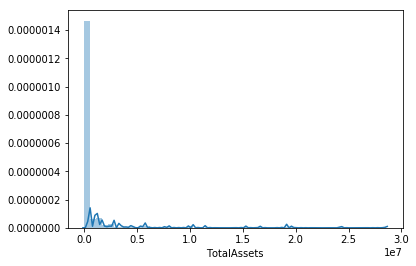

In [18]:
sns.distplot(companies['TotalAssets'])

In [19]:
companies['TotalAssets'].describe()

count    4.010000e+02
mean     8.200689e+05
std      3.040920e+06
min      2.200000e+01
25%      4.036000e+03
50%      1.340800e+04
75%      1.393660e+05
max      2.856618e+07
Name: TotalAssets, dtype: float64

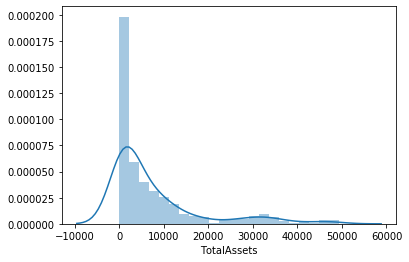

In [14]:
def normalize_statement_rounding(companies):
    
    balance_sheet_items = ['Cash', 'MarketableSec', 'AcctsRecTrade', 'BadDebtReserve', 'NetTradeAcctsRec', 'AcctsRecOther', 'RawMaterialsInv', 'WIPInv', 'FinGoodsInv', 'OtherInv', 'TotalInventory', 'IncTaxReceivable', 'CostsInExcBill', 'OtherOperAssets', 'NonOpCurAssets', 'LifoReserve', 'OffBSCurAsts', 'TotalCurAssets', 'DefIncTaxRec', 'ConstInProgress', 'Land', 'FixedAssets', 'GrossFixedAssets', 'AccumDeprec', 'NetFixedAssets', 'LongTermAcctsRec', 'LongTermInvest', 'OpNonCurAssets', 'LongTermPrepaids', 'NonOpNonCurAsts', 'Intangibles', 'AccumAmort', 'NetIntangibles', 'OffBSNonCurAsts', 'TotalNonCurAsts', 'TotalAssets', 'Overdrafts', 'STLoansPayable', 'CPLTD', 'CPSubDebt', 'AcctsPayTrade', 'AcctsPayOther', 'AccruedLiabs', 'InterestPayable', 'DividendsPayable', 'TotalAccrdLiabs', 'IncTaxesPayable', 'OtherOperLiabs', 'BillInexcCosts', 'NonOpCurLiabs', 'OffBSCurLiabs', 'TotalCurLiabs', 'LongTermDebt', 'CapLeaseOblig', 'DefIncTaxPayable', 'NonOpNonCurLiabs', 'OpNonCurLiabs', 'DueToRelParty', 'OffBSNonCurLiabs', 'SubDebtLiabs', 'MinorityIntLiabs', 'TotalNonCurLiabs', 'TotalLiabs', 'SubDebtEquity', 'MinIntEquity', 'PreferredStock', 'CommonStock', 'OtherEquity', 'TreasuryStock', 'CurrencyTranslat', 'RetainedEarnings', 'AccumulatedOCI', 'TotalNetWorth', 'TotLiabsNetWorth']
    income_statement_items = ['GrossSales', 'SalesReturns', 'NetSales', 'CostOfGoodsSold', 'COGSDepreciation', 'TotalCOGS', 'GrossProfit', 'OperExpenses', 'SellingAndGenExp', 'OfficersComp', 'LeaseRentExp', 'DeprecExpense', 'AmortExpense', 'ESOPDividends', 'TotalOpExpenses', 'OtherOperIncome', 'NetOpProfit', 'InterestIncome', 'InterestExpense', 'NonCashIncome', 'NonCashExpense', 'OtherIncome', 'IncomeFromSubs', 'GainLossAstSale', 'OtherExpense', 'TotalOtherIncExp', 'ProfitBeforeTax', 'IncomeTaxExp', 'IncomeTaxCredit', 'NetIncomeTaxExp', 'MinorityIntExp', 'ProfitB4ExtItems', 'AfterTaxIncome', 'AftTaxNonCashExp', 'AfterTaxExpense', 'NetProfit', 'OtherCompIncome', 'CompIncome', 'DividendsStock', 'DividendsCommon', 'DividendsPref', 'AdjToRE']
    other_items = ['OCF']
    
    def normalize_values(row):
        if row['TotalAssets'] > 50000:
            row[balance_sheet_items] = row[balance_sheet_items] / 1000.0
            row[income_statement_items] = row[income_statement_items] / 1000.0
            row[other_items] = row[other_items] / 1000.0
        return row
    
    companies = companies.apply(normalize_values, axis=1)
    
    return companies

companies = normalize_statement_rounding(companies)
sns.distplot(companies['TotalAssets'])

### Part IV: Further Validation

Identify structural outliers

In [15]:
companies['GrossProfittoTotalAssets'] = companies['GrossProfit'] / companies['TotalAssets']
companies['Capitalization_Ratio'] = companies['LongTermDebt'] / (companies['LongTermDebt'] + companies['TotalNetWorth'])
companies['CashFlowMargin'] = companies['OCF'] / companies['NetSales']

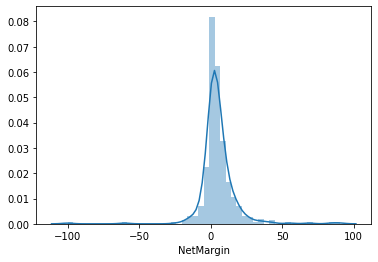

In [16]:
sns.distplot(companies['NetMargin'].fillna(0.0))

In [17]:
companies['NetMargin'].describe()

count    400.000000
mean       5.039730
std       12.421015
min     -100.000000
25%        0.849377
50%        3.330263
75%        8.119367
max       90.395480
Name: NetMargin, dtype: float64

In [17]:
sns.distplot(companies['GrossProfittoTotalAssets'])

KeyError: 'GrossProfittoTotalAssets'

In [19]:
companies['GrossProfittoTotalAssets'].describe()

count    401.000000
mean       0.611053
std        0.883812
min       -0.014408
25%        0.225153
50%        0.383645
75%        0.694877
max       11.344340
Name: GrossProfittoTotalAssets, dtype: float64

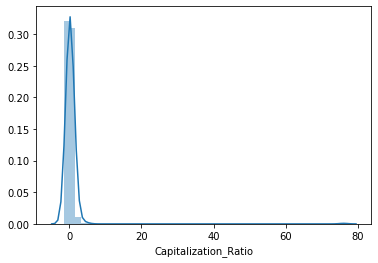

In [20]:
sns.distplot(companies['Capitalization_Ratio'])

In [21]:
companies['Capitalization_Ratio'].describe()

count    401.000000
mean       0.514494
std        3.816278
min       -1.354115
25%        0.007141
50%        0.193220
75%        0.443561
max       76.000000
Name: Capitalization_Ratio, dtype: float64

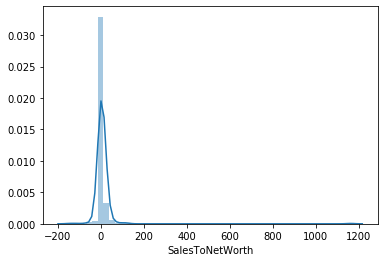

In [22]:
sns.distplot(companies['SalesToNetWorth'])

In [23]:
companies['SalesToNetWorth'].describe()

count     401.000000
mean        8.495468
std        60.242141
min      -144.500000
25%         1.975782
50%         3.537915
75%         7.064559
max      1161.500000
Name: SalesToNetWorth, dtype: float64

In [24]:
companies['SalesToNetWorth'].quantile(0.95)

27.002409000000004

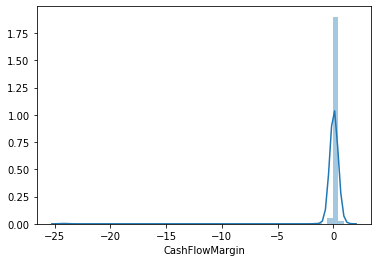

In [25]:
sns.distplot(companies['CashFlowMargin'].fillna(0.0).replace(np.inf, 0.0).replace(-np.inf, 0.0))

In [26]:
companies['CashFlowMargin'].describe()

count    366.000000
mean           -inf
std             NaN
min            -inf
25%        0.018003
50%        0.051939
75%        0.101853
max        0.953488
Name: CashFlowMargin, dtype: float64

In [27]:
companies['CashFlowMargin'].quantile(0.01)

-0.2759967965005308

In [28]:
# ratio based filtering
# remove companies at extreme ends of distributions

def filter_outliers(companies):
    companies = companies[companies['NetMargin'] > -100.0]
    companies = companies[companies['GrossProfittoTotalAssets'] < 2.0]
    companies = companies[companies['Capitalization_Ratio'].between(0.0, 30.0)]
    companies = companies[companies['SalesToNetWorth'].between(0.0, 50.0)]
    companies = companies[companies['CashFlowMargin'].between(-1.0, 1.0)]
    
    return companies

companies = filter_outliers(companies)
print (companies.shape)

(316, 304)


### K-Means Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA\
from sklearn.preprocessing import StandardScaler

In [30]:
companies['AuditMethod'].value_counts()999

Co.Prep'd     112
Unqualif'd     79
Reviewed       65
Compiled       27
Tax Return     27
Qualified       5
10Q             1
Name: AuditMethod, dtype: int64

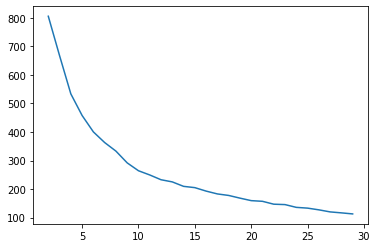

In [31]:
features = ['NetMargin',
           'GrossProfittoTotalAssets',
           'Capitalization_Ratio',
           'SalesToNetWorth',
           'CashFlowMargin']

X = companies[features].fillna(0.0).replace(np.inf, 0.0).replace(-np.inf, 0.0)[companies['IndustryType'] == 'Manufacturing']
X_std = StandardScaler().fit_transform(X)
sse = []

for k in range(2, 30):
    km = KMeans(n_clusters=k).fit(X_std)
    sse.append(km.inertia_)
    
plt.plot(range(2,30), sse)


In [32]:
km = KMeans(n_clusters=10).fit(X_std)
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 5, 49, 10, 14, 35, 15,  1,  4, 28, 42]))

In [33]:
X[km.labels_ == 7]

,NetMargin,GrossProfittoTotalAssets,Capitalization_Ratio,SalesToNetWorth,CashFlowMargin
103,0.595202,0.336353,0.561312,21.671684,0.052490
423,0.352294,0.579087,0.871548,30.833658,0.027763
593,-4.052626,0.148375,0.420084,30.623193,-0.016358
618,1.924505,0.395815,0.845482,27.002409,0.085964


No handles with labels found to put in legend.


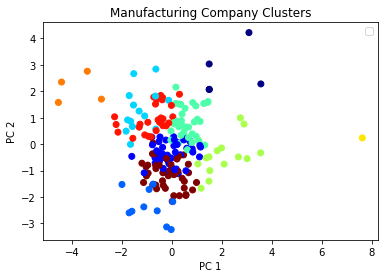

In [34]:
X_pca = PCA(n_components=2).fit_transform(X_std)
plt.set_cmap('jet')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_)
plt.title('Manufacturing Company Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

### Days Payable - Manufacturing

In [35]:
manufacturing = companies[companies['IndustryType'] == 'Manufacturing']
print (manufacturing.shape)

(203, 304)


In [36]:
print ('Mean DPO %.2f' % manufacturing['AcctsPayableDays'].mean())

Mean DPO 33.65


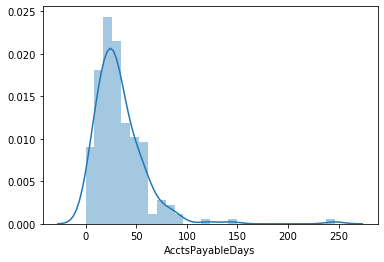

In [37]:
sns.distplot(manufacturing['AcctsPayableDays'].dropna())

In [40]:
# what are good candidates for a working capital partnership?
display_fields = ['masked EntityID', 'CustomerName', 'IndustryCode', 'StatementYear', 'AcctsPayableDays', 
                  'GrossMargin', 'TotalCOGS', 'AcctsPayTrade']
manufacturing[display_fields][manufacturing['AcctsPayableDays'] < manufacturing['AcctsPayableDays'].quantile(0.05)].round(2)

,masked EntityID,CustomerName,IndustryCode,StatementYear,AcctsPayableDays,GrossMargin,TotalCOGS,AcctsPayTrade
130,45825,Essential Physicians Group,332919,2018,2.07,37.30,5639.00,32.0
136,2731,Trustworthy Poultry Products,332312,2015,2.71,37.91,12516.00,93.0
201,145077,Sugarbush Marketing Consultant,332322,2017,7.19,40.15,5026.00,99.0
214,39570,Harborside Diagnostic Imaging Center,332613,2018,2.51,38.81,14562.00,100.0
219,33344,Main Electronic Marketing,332721,2012,2.58,43.53,2126.00,15.0
273,2590,Goldpan Art Gallery,332710,2012,0.00,48.42,1191.00,0.0
415,119735,Varsity Exam Preparation,332710,2018,5.60,47.86,2477.00,38.0
850,182359,Founders Periodical Publishers,332813,2017,2.78,25.16,6440.00,49.0
919,148437,Los Altos Publishers,332119,2018,5.26,20.56,12006.00,173.0
1050,887899,Meadow Grass Home Furnishing Store,311821,2017,0.00,16.30,3177.84,0.0


In [39]:
manufacturing[manufacturing['AuditMethod'] == '10Q']

,masked EntityID,CPR $net_inc_YTD,CPR_Group,CPR_rm,IndustryCode,IndustryType,CustomerID,StatementID,CustomerName,StatementMonths,AuditMethod,Accountant,Analyst,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,OffBSCurAsts,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,GrossFixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,OffBSNonCurAsts,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,OtherOperIncome,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,IncomeTaxCredit,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AftTaxNonCashExp,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,WorkingCapital,QuickRatio,CurrentRatio,TangibleNetWorth,EffTangNetWorth,DebtToWorth,DebtToTNW,DbtLessSubEffTNW,LiabsToAssets,InterestCoverage,FndsFlwToPpCPLTD,UCACashFlowCover,CashFlwToPpCPLTD,EBITDA,EBIDA,FixedChargeCover,ReturnOnAssets,ReturnOnEquity,GrossMargin,OpProfitMargin,DivPayoutRate,EffectiveTaxRate,GrsAcctsRecDays,NetAcctsRecDays,RawMatInvDays,WIPInvDays,FinGoodsInvDays,TotalInvDays,AcctsPayableDays,SalesToTotalAsts,SalesToWrkingCap,SalesToNetWorth,SalesToFixedAsts,PBTToTotalAssets,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,SustainableGrow,CashClctdFrSales,CashPdToSupplrs,CashFrTradActiv,CashPdForOpCosts,CashAfterOps,OthIncAndTaxesPd,NetCashAfterOps,CashPdDivAndInt,NetCashIncome,CPLTDPaid,CashAftDebtAmort,ChgInFixedAssets,FixedAssetsToTNW,ProfitB4TaxToTNW,DepAmortToSales,OffrCompToSales,SalesToAcctsRec,COGSToInventory,COGSToAcctsPay,PBTToNetSales,OtherCurAssets,OtherNonCurAsts,OtherCurLiabs,OtherNonCurLiabs,StatementYear,CashAndEquivs,NetMargin,NetIncDeprtoCPLTD,AcctsRecRelCo,OverdraftsInt,BorrFundtoEffTgWth,EBITDAtoIntCPLTD,CapInterest,AdjustedEBITDA,AdjustedEBITDAGrowth,AdjustedEBITDAMargin,GrossProfitGrowth,ImpliedCFGRating,OCF,SeniorFundedDebt,SFDtoAdjEBITDA,TFDtoAdjEBITDA,TotalFundedDebt,ZScore,ChgInWorkingInvestment,TangibleCapitalBase,MaintenanceCapX,SynergiesAddbacks,CashTaxes,RecurringDistributions,ExtraordinaryItems,OCFADSR,OCFCapXADSR,OCFCapXWIADSR,ChginGrossFixedAssets,Inventory,BuildingsImprovements,MachineryEquipment,FurnitureFixtures,LeaseholdImprovements,TransportationEquipment,CapitalLeases,DepreciationandAmortization,GainOnDeriv,LossOnDeriv,GainonAssetReval,LossonAssetReval,GainLossonAssetSale,FCFtoNetAdjustedDebt,FFOtoNetAdjustedDebt,RCFCapextoAdjustedDebt,RCFtoNetAdjustedDebt,CapextoCFO,RCFtoAdjustedDebt,FCFtoAdjustedDebt,FFOtoAdjustedDebt,CFOtoProfitBefExtraordItems,PriorPeriodAdjustments,LTD_TO_CAPITALIZATION_RT,CHANGE_IN_LEVERAGE_RT,DEBT_TO_EBITDA_RT,CASH_TO_TOTAL_LIABILITIES_RT,CHANGE_IN_WC_TO_SALES_RT,ADJ_DEBT_TO_EBITDA_RT,CASH_TO_SALES_RT,OCF_TO_CPLTD_IE_RT,EBIT_INTEREST_COVERAGE_RT,ADJ_FIX_CHARGE_COVERAGE_RT,TOT_LIAB_TO_TANG_NET_WORTH_RT,TOTAL_EXPENSE_TO

## Commercial Banking Records Analysis

Per Peter Macero - "you may be able to cull records under the assumption that anything having a “CPR_Group” of ‘commerical banking’ (tab1, column c) is less likely to have an input error".

Let's look through these records and see if there's higher value available.

In [84]:
commercial = companies[companies['CPR_Group'] == 'COMMERCIAL BANKING']
print (commercial.shape)

(81, 308)


### Days of Payables Analysis - Commercial Banking Group

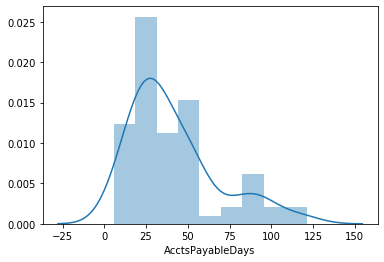

In [85]:
sns.distplot(commercial['AcctsPayableDays'][commercial['AcctsPayableDays'].between(1, 500)])

In [86]:
# for which borrowers should we have triggered a DPO enhancement?
commercial[commercial['AcctsPayableDays'].between(1, 20)]

,masked EntityID,CPR $net_inc_YTD,CPR_Group,CPR_rm,IndustryCode,IndustryType,CustomerID,StatementID,CustomerName,StatementMonths,AuditMethod,Accountant,Analyst,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,OffBSCurAsts,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,GrossFixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,OffBSNonCurAsts,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,OtherOperIncome,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,IncomeTaxCredit,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AftTaxNonCashExp,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,WorkingCapital,QuickRatio,CurrentRatio,TangibleNetWorth,EffTangNetWorth,DebtToWorth,DebtToTNW,DbtLessSubEffTNW,LiabsToAssets,InterestCoverage,FndsFlwToPpCPLTD,UCACashFlowCover,CashFlwToPpCPLTD,EBITDA,EBIDA,FixedChargeCover,ReturnOnAssets,ReturnOnEquity,GrossMargin,OpProfitMargin,DivPayoutRate,EffectiveTaxRate,GrsAcctsRecDays,NetAcctsRecDays,RawMatInvDays,WIPInvDays,FinGoodsInvDays,TotalInvDays,AcctsPayableDays,SalesToTotalAsts,SalesToWrkingCap,SalesToNetWorth,SalesToFixedAsts,PBTToTotalAssets,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,SustainableGrow,CashClctdFrSales,CashPdToSupplrs,CashFrTradActiv,CashPdForOpCosts,CashAfterOps,OthIncAndTaxesPd,NetCashAfterOps,CashPdDivAndInt,NetCashIncome,CPLTDPaid,CashAftDebtAmort,ChgInFixedAssets,FixedAssetsToTNW,ProfitB4TaxToTNW,DepAmortToSales,OffrCompToSales,SalesToAcctsRec,COGSToInventory,COGSToAcctsPay,PBTToNetSales,OtherCurAssets,OtherNonCurAsts,OtherCurLiabs,OtherNonCurLiabs,StatementYear,CashAndEquivs,NetMargin,NetIncDeprtoCPLTD,AcctsRecRelCo,OverdraftsInt,BorrFundtoEffTgWth,EBITDAtoIntCPLTD,CapInterest,AdjustedEBITDA,AdjustedEBITDAGrowth,AdjustedEBITDAMargin,GrossProfitGrowth,ImpliedCFGRating,OCF,SeniorFundedDebt,SFDtoAdjEBITDA,TFDtoAdjEBITDA,TotalFundedDebt,ZScore,ChgInWorkingInvestment,TangibleCapitalBase,MaintenanceCapX,SynergiesAddbacks,CashTaxes,RecurringDistributions,ExtraordinaryItems,OCFADSR,OCFCapXADSR,OCFCapXWIADSR,ChginGrossFixedAssets,Inventory,BuildingsImprovements,MachineryEquipment,FurnitureFixtures,LeaseholdImprovements,TransportationEquipment,CapitalLeases,CREATE_BY_NM,CREATE_BY_DT,LAST_UPDATE_BY_NM,LAST_UPDATE_BY_DT,DepreciationandAmortization,GainOnDeriv,LossOnDeriv,GainonAssetReval,LossonAssetReval,GainLossonAssetSale,FCFtoNetAdjustedDebt,FFOtoNetAdjustedDebt,RCFCapextoAdjustedDebt,RCFtoNetAdjustedDebt,CapextoCFO,RCFtoAdjustedDebt,FCFtoAdjustedDebt,FFOtoAdjustedDebt,CFOtoProfitBefExtraordItems,PriorPeriodAdjustments,LTD_TO_CAPITALIZATION_RT,CHANGE_IN_LEVERAGE_RT,DEBT_TO_EBITDA_RT,CASH_TO_TOTAL_LIABILITIES_RT,CHANGE_IN_WC_TO_SALES_RT,ADJ_DEBT_TO_EBITDA_RT,CASH_TO_SALES_RT,OCF_TO_CPLTD_IE_RT,EBIT_INTEREST_COVERAGE_RT,ADJ_FIX_CHA

In [87]:
def group_field_by_industry(df, field):
    return df.groupby('IndustryType').mean()[field]

In [88]:
group_field_by_industry(commercial, 'AcctsPayableDays')

IndustryType
Agriculture      22.376803
Construction     62.583980
Manufacturer     39.040972
Manufacturing    38.561681
Other            27.937958
Real Estate            NaN
Service                NaN
Wholesale        23.766551
Name: AcctsPayableDays, dtype: float64

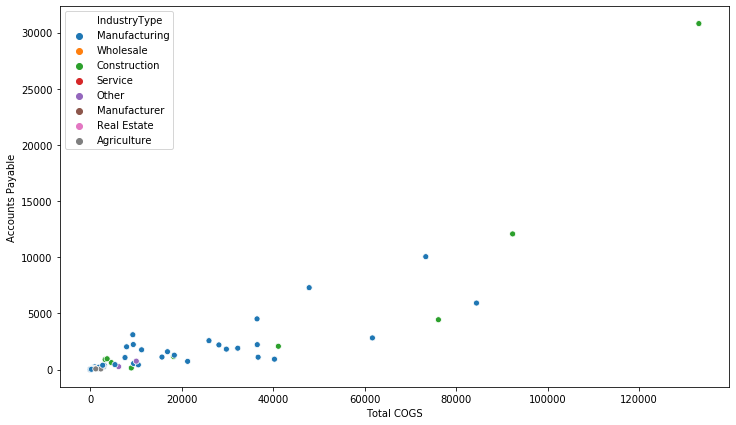

In [89]:
# commercial['AcctsPayableDays'].corr(commercial['TotalCOGS'])
# is there any payment term pricing power as a company grows?
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(ax=ax, 
                x=commercial['TotalCOGS'], 
                y=commercial['AcctsPayTrade'], 
                hue=commercial['IndustryType'])
ax.set_xlabel('Total COGS')
ax.set_ylabel('Accounts Payable')
plt.show()

### Cash Conversion Cycle

In [43]:
commercial['CCC'] = commercial['TotalInvDays'] + commercial['NetAcctsRecDays'] - commercial['AcctsPayableDays']

/Users/zachangell/.local/share/virtualenvs/django-api-6GOErhFP/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
group_field_by_industry(commercial, 'CCC')

IndustryType
Agriculture      34.900868
Construction     30.665395
Manufacturer     22.773743
Manufacturing    77.320626
Other            26.940103
Real Estate            NaN
Service                NaN
Wholesale        42.630263
Name: CCC, dtype: float64

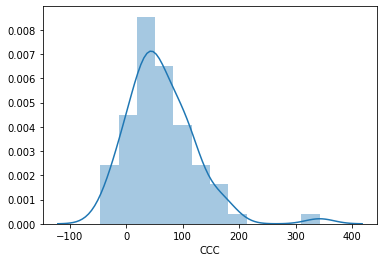

In [45]:
sns.distplot(commercial[commercial['CCC'].between(-100, 365)]['CCC'])

In [46]:
group_field_by_industry(commercial, 'TotalInvDays')

IndustryType
Agriculture      35.673336
Construction     24.979930
Manufacturer     41.423133
Manufacturing    70.521568
Other            27.716493
Real Estate            NaN
Service                NaN
Wholesale        30.729892
Name: TotalInvDays, dtype: float64

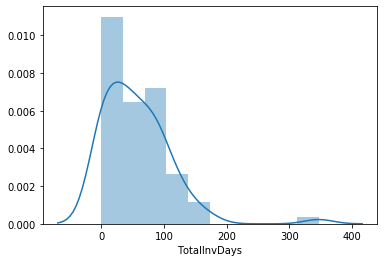

In [47]:
sns.distplot(commercial[commercial['TotalInvDays'].between(-100, 365)]['TotalInvDays'])

In [48]:
group_field_by_industry(commercial, 'NetAcctsRecDays')

IndustryType
Agriculture      21.604335
Construction     68.269445
Manufacturer     20.391582
Manufacturing    44.488417
Other            27.161568
Real Estate      21.136516
Service           0.000000
Wholesale        35.666922
Name: NetAcctsRecDays, dtype: float64

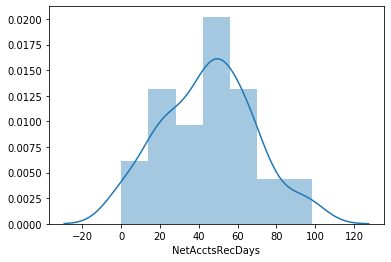

In [49]:
sns.distplot(commercial[commercial['NetAcctsRecDays'].between(-100, 365)]['NetAcctsRecDays'])

### M&A Candidates - Commercial Banking Group

In [50]:
commercial['CashPct'] = commercial['Cash'] / commercial['TotalAssets']
commercial['DE'] = commercial['TotalLiabs'] / commercial['TotalNetWorth'] 

/Users/zachangell/.local/share/virtualenvs/django-api-6GOErhFP/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zachangell/.local/share/virtualenvs/django-api-6GOErhFP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


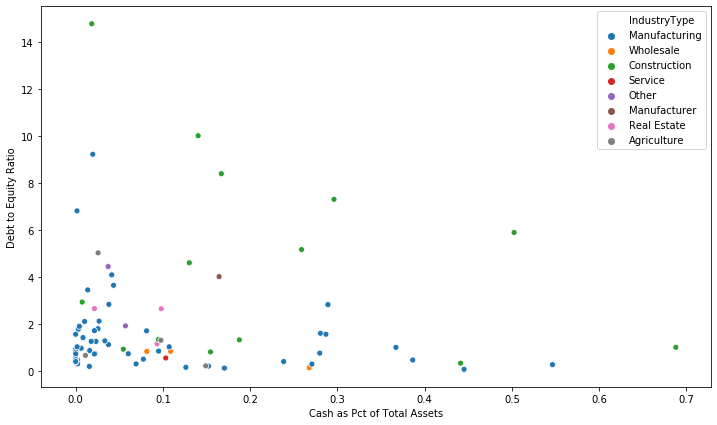

In [51]:
de_ratio_mask = commercial['DE'].between(0, 30)

fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(ax=ax,
                
                x=commercial[de_ratio_mask]['CashPct'], 
                y=commercial[de_ratio_mask]['DE'], 
                hue=commercial[de_ratio_mask]['IndustryType'])
ax.set_xlabel('Cash as Pct of Total Assets')
ax.set_ylabel('Debt to Equity Ratio')
plt.show()

In [52]:
commercial[commercial['CashPct'] > 0.65]

,masked EntityID,CPR $net_inc_YTD,CPR_Group,CPR_rm,IndustryCode,IndustryType,CustomerID,StatementID,CustomerName,StatementMonths,AuditMethod,Accountant,Analyst,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,OffBSCurAsts,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,GrossFixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,OffBSNonCurAsts,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,OtherOperIncome,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,IncomeTaxCredit,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AftTaxNonCashExp,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,WorkingCapital,QuickRatio,CurrentRatio,TangibleNetWorth,EffTangNetWorth,DebtToWorth,DebtToTNW,DbtLessSubEffTNW,LiabsToAssets,InterestCoverage,FndsFlwToPpCPLTD,UCACashFlowCover,CashFlwToPpCPLTD,EBITDA,EBIDA,FixedChargeCover,ReturnOnAssets,ReturnOnEquity,GrossMargin,OpProfitMargin,DivPayoutRate,EffectiveTaxRate,GrsAcctsRecDays,NetAcctsRecDays,RawMatInvDays,WIPInvDays,FinGoodsInvDays,TotalInvDays,AcctsPayableDays,SalesToTotalAsts,SalesToWrkingCap,SalesToNetWorth,SalesToFixedAsts,PBTToTotalAssets,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,SustainableGrow,CashClctdFrSales,CashPdToSupplrs,CashFrTradActiv,CashPdForOpCosts,CashAfterOps,OthIncAndTaxesPd,NetCashAfterOps,CashPdDivAndInt,NetCashIncome,CPLTDPaid,CashAftDebtAmort,ChgInFixedAssets,FixedAssetsToTNW,ProfitB4TaxToTNW,DepAmortToSales,OffrCompToSales,SalesToAcctsRec,COGSToInventory,COGSToAcctsPay,PBTToNetSales,OtherCurAssets,OtherNonCurAsts,OtherCurLiabs,OtherNonCurLiabs,StatementYear,CashAndEquivs,NetMargin,NetIncDeprtoCPLTD,AcctsRecRelCo,OverdraftsInt,BorrFundtoEffTgWth,EBITDAtoIntCPLTD,CapInterest,AdjustedEBITDA,AdjustedEBITDAGrowth,AdjustedEBITDAMargin,GrossProfitGrowth,ImpliedCFGRating,OCF,SeniorFundedDebt,SFDtoAdjEBITDA,TFDtoAdjEBITDA,TotalFundedDebt,ZScore,ChgInWorkingInvestment,TangibleCapitalBase,MaintenanceCapX,SynergiesAddbacks,CashTaxes,RecurringDistributions,ExtraordinaryItems,OCFADSR,OCFCapXADSR,OCFCapXWIADSR,ChginGrossFixedAssets,Inventory,BuildingsImprovements,MachineryEquipment,FurnitureFixtures,LeaseholdImprovements,TransportationEquipment,CapitalLeases,CREATE_BY_NM,CREATE_BY_DT,LAST_UPDATE_BY_NM,LAST_UPDATE_BY_DT,DepreciationandAmortization,GainOnDeriv,LossOnDeriv,GainonAssetReval,LossonAssetReval,GainLossonAssetSale,FCFtoNetAdjustedDebt,FFOtoNetAdjustedDebt,RCFCapextoAdjustedDebt,RCFtoNetAdjustedDebt,CapextoCFO,RCFtoAdjustedDebt,FCFtoAdjustedDebt,FFOtoAdjustedDebt,CFOtoProfitBefExtraordItems,PriorPeriodAdjustments,LTD_TO_CAPITALIZATION_RT,CHANGE_IN_LEVERAGE_RT,DEBT_TO_EBITDA_RT,CASH_TO_TOTAL_LIABILITIES_RT,CHANGE_IN_WC_TO_SALES_RT,ADJ_DEBT_TO_EBITDA_RT,CASH_TO_SALES_RT,OCF_TO_CPLTD_IE_RT,EBIT_INTEREST_COVERAGE_RT,ADJ_FIX_CHA

In [53]:
commercial[commercial['CashPct'] > 0.65]['StatementYear']

230    2018
Name: StatementYear, dtype: int64

### ROE

In [ ]:
group_field_by_industry(commercial, 'ReturnOnEquity')

In [ ]:
sns.distplot(commercial[commercial['ReturnOnEquity'].between(-100,100)]['ReturnOnEquity'])

In [ ]:
group_field_by_industry(commercial, 'ReturnOnAssets')

In [ ]:
sns.distplot(commercial[commercial['ReturnOnAssets'].between(-100,100)]['ReturnOnAssets'])

In [ ]:
group_field_by_industry(commercial, 'NetMargin')

In [ ]:
sns.distplot(commercial['NetMargin'].fillna(0.0))

In [ ]:
# TODO

# cleaning
# cleanup Analyst column (is this valuable?)
# consistency checks:
# - ratios

# analyses
# inventory analysis (manufacturing cos)
# construction in progress analysis (construction cos)
# M&A candidates (a lot of cash on hand)
# working capital analysis
# - DPO
# - CCC
# clustering using ratios?

### Financial Health

In [ ]:
group_field_by_industry(commercial, 'ZScore')